In [1]:
import pandas as pd
import sqlalchemy as sa
import pyodbc
import numpy as np
pd.options.display.float_format = '{:,.0f}'.format

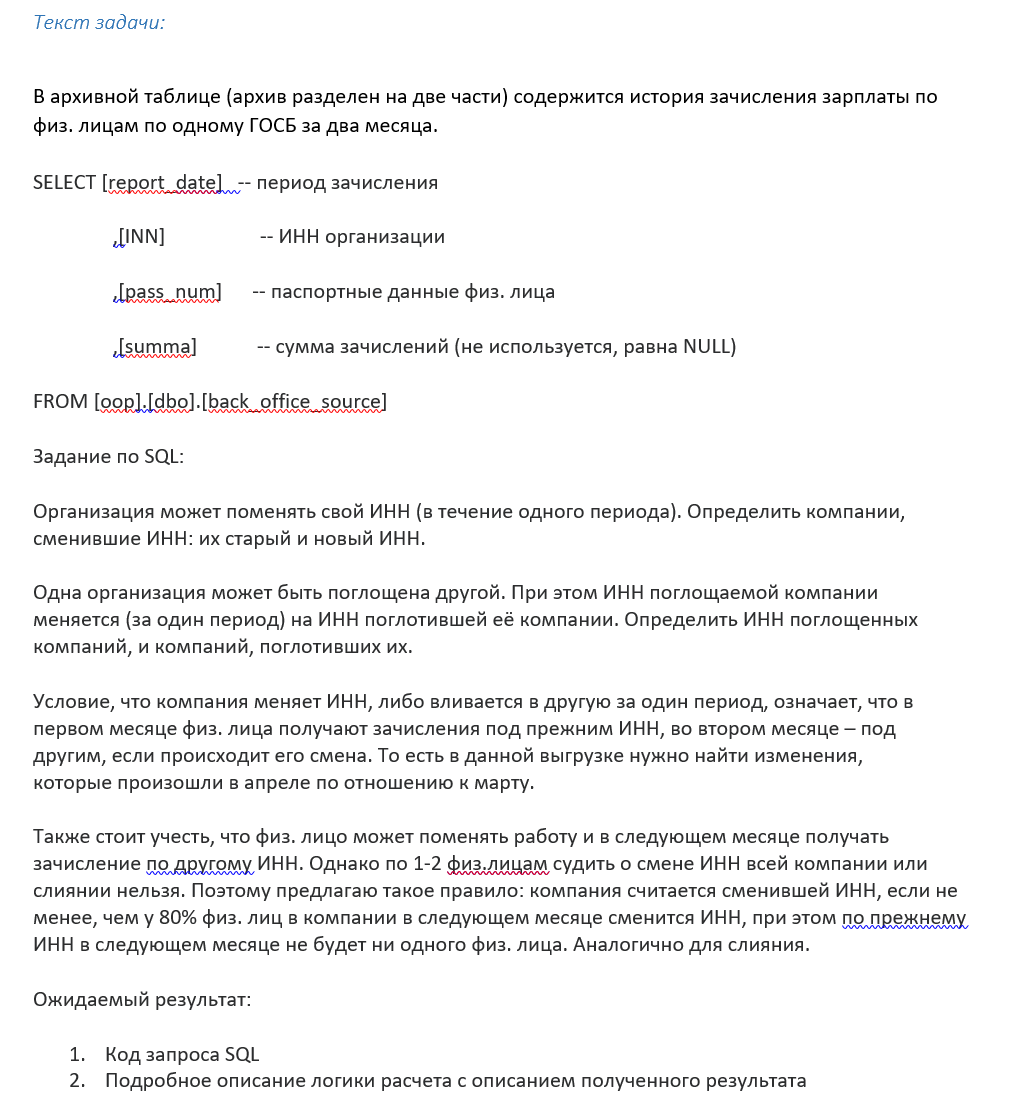

In [1]:
from PIL import Image
Image.open('Задание.png')

### Распаковали датасет, загружаем данные

In [2]:
df = pd.read_csv('exp.txt',sep=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599217 entries, 0 to 599216
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   report_date  599217 non-null  object 
 1   inn          599217 non-null  int64  
 2   pass_num     599217 non-null  object 
 3   summa        0 non-null       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 18.3+ MB


In [4]:
df.sample(10)

,report_date,inn,pass_num,summa
263221,2016-03-31,2925005600,0x3E655369C62D4C5F31665F64EF6804934BEB4C6C7BFB...,NaN
9144,2016-03-31,2907001867,0x13968EE0439FA1762315BB165F561300C02AF3C49680...,NaN
421810,2016-04-30,2913003862,0xEB020AFD32BE0300F54998839029B54BDEA6E2AC90DF...,NaN
71590,2016-03-31,2902060361,0xB9E7B69C7E554B5455ECB1CF6D34A3ED4A0CB8968F79...,NaN
99005,2016-03-31,2923003371,0x1CABD45668FA690C826CC43E2A36E154594BF887F028...,NaN
227344,2016-03-31,7707083893,0x1983385E9A653E0B535C7CD32061F1761937CE52AC3B...,NaN
298806,2016-04-30,2923006894,0x8A80C6281569345E1FE602138FBBDFC6D7EF2C61D56D...,NaN
586625,2016-04-30,2901112320,0x926A8181041F52D2C812A63586C8198B14E2D2E8DF97...,NaN
148565,2016-03-31,2904023260,0x9C6F4E73AE1AECD658AD39FD432F8783DA624B53A2C2...,NaN
128405,2016-03-31,2901257566,0xF2B1AAF1297E2587EC64414768F80BBD7B0DA073C272...,NaN


In [5]:
engine = sa.create_engine('mssql+pyodbc://(localdb)\MSSQLLocalDB/vpolyanchikov?driver=ODBC Driver 17 for SQL Server')

In [6]:
def read_sql(query, engine):
    df = pd.read_sql_query(query, engine)
    engine.dispose()
    return df

In [7]:
def execute_sql(query, engine):
    conn = engine.connect()
    result = conn.execute(query + "; commit;")
    engine.dispose()
    return result

In [8]:
def to_sql(df, tables, engine, schema='dbo',if_exist='append'):
    df.to_sql(name=tables, con=engine,
                  schema=schema, if_exists=if_exist, index=0)
    engine.dispose()
    return

In [ ]:
execute_sql("""CREATE TABLE back_office_source
                (report_date date,
                INN numeric,
                pass_num varchar(300),
                summa float)
                """, engine)

In [9]:
to_sql(df, 'back_office_source', engine)

In [10]:
read_sql("""SELECT count(*) as cnt  FROM back_office_source""", engine)

,cnt
0,1797651


## Финал

#### Одна организация может быть поглощена другой. При этом ИНН поглощаемой компании меняется (за один период) на ИНН поглотившей её компании. Определить ИНН поглощенных компаний, и компаний, поглотивших их.

In [11]:
query = """
SET ANSI_NULLS,
    QUOTED_IDENTIFIER ON;
SET NOCOUNT,
    XACT_ABORT ON;
SET ANSI_WARNINGS ON;

DROP TABLE IF EXISTS #table1;
DROP TABLE IF EXISTS #table2;
DROP TABLE IF EXISTS #table3;
DROP TABLE IF EXISTS #table4;
DROP TABLE IF EXISTS #table5;
DROP TABLE IF EXISTS #table6;

CREATE TABLE #table1 (INN_march Numeric     NULL,
                      INN_april Numeric     NULL,
                      "Плечо" varchar(40)   NULL,
                      "Кол-во плеч" numeric NULL);

INSERT INTO #table1
SELECT m.INN_march ,
       a.INN_april ,
       CONCAT(m.INN_march, '-', a.INN_april) AS "Плечо" ,
       COUNT(CONCAT(m.INN_march, '-', a.INN_april)) AS "Кол-во плеч"
FROM
  (SELECT pass_num AS pass_num ,
          INN AS INN_march
   FROM vpolyanchikov.dbo.back_office_source
   WHERE report_date = '2016-03-31'
   GROUP BY pass_num,
            INN) m
INNER JOIN
  (SELECT pass_num AS pass_num ,
          INN AS INN_april
   FROM vpolyanchikov.dbo.back_office_source
   WHERE report_date = '2016-04-30'
   GROUP BY pass_num,
            INN) a ON m.pass_num = a.pass_num
WHERE inn_march != inn_april
GROUP BY m.inn_march,
         a.INN_april,
         CONCAT(m.INN_march, '-', a.INN_april);


SELECT a.* ,
       ma.cnt_march 
INTO #table2
FROM #table1 a
LEFT JOIN
  (SELECT INN ,
          count(distinct(pass_num)) AS cnt_march
   FROM vpolyanchikov.dbo.back_office_source
   WHERE report_date = '2016-03-31'
   GROUP BY INN) ma ON a.inn_march = ma.inn;


SELECT a.* ,
       COALESCE(ap.cnt_april, 0) AS cnt_april 
INTO #table3
FROM #table2 a
LEFT JOIN
  (SELECT INN ,
          count(distinct(pass_num)) AS cnt_april
   FROM vpolyanchikov.dbo.back_office_source
   WHERE report_date = '2016-04-30'
   GROUP BY INN) ap ON a.inn_march = ap.inn;


SELECT * ,
       ROUND(("Кол-во плеч" / cnt_march) * 100, 2) AS percentmoved ,
       CASE
           WHEN cnt_april = 0 THEN 1
           ELSE 0
       END AS flag_zero ,
       CASE
           WHEN ("Кол-во плеч" / cnt_march) >= 0.8 THEN 1
           ELSE 0
       END AS flag80changed 
INTO #table4
FROM #table3;


SELECT a.* ,
       COALESCE(ma.cnt_march_new, 0) AS cnt_march_new 
INTO #table5
FROM #table4 a
LEFT JOIN
  (SELECT INN ,
          count(distinct(pass_num)) AS cnt_march_new
   FROM vpolyanchikov.dbo.back_office_source
   WHERE report_date = '2016-03-31'
   GROUP BY INN) ma ON a.inn_april = ma.inn;

SELECT a.* ,
       COALESCE(ma.cnt_april_new, 0) AS cnt_april_new 
INTO #table6
FROM #table5 a
LEFT JOIN
  (SELECT INN ,
          count(distinct(pass_num)) AS cnt_april_new
   FROM vpolyanchikov.dbo.back_office_source
   WHERE report_date = '2016-04-30'
   GROUP BY INN) ma ON a.inn_april = ma.inn;

SELECT inn_march AS "ИНН Старый / Поглощаемой"
       , inn_april AS "ИНН Новый / Поглощателя"
       , "Плечо" AS "Плечо перехода"
       , "Кол-во плеч" AS "Кол-во переходов"
       , cnt_march as "Кол-во сотрудников в марте"
       , cnt_march_new as "Кол-во сотрудников в марте у Поглощателя / Новой компании"
       , cnt_april_new as "Кол-во сотрудников в апреле у Поглощателя / Новой компании"
       , CAST(percentmoved AS INT) AS "Процент перешедших в Поглощатель"
       , CASE
           WHEN cnt_march_new = 0 THEN 'New'
           ELSE 'M&A'
       END AS "Тип перехода"
FROM #table6
WHERE flag_zero = 1
    AND flag80changed = 1
    --AND cnt_march > 2
ORDER BY "Кол-во плеч" DESC;
"""

In [12]:
df4 = read_sql(query, engine)
df4

,ИНН Старый / Поглощаемой,ИНН Новый / Поглощателя,Плечо перехода,Кол-во переходов,Кол-во сотрудников в марте,Кол-во сотрудников в марте у Поглощателя / Новой компании,Кол-во сотрудников в апреле у Поглощателя / Новой компании,Процент перешедших в Поглощатель,Тип перехода
0,"2,901,008,305","2,901,110,813",2901008305-2901110813,159,181,36,262,87,M&A
1,"8,300,130,171","8,300,010,685",8300130171-8300010685,91,96,170,287,94,M&A
2,"2,901,087,106","2,901,110,813",2901087106-2901110813,41,44,36,262,93,M&A
3,"2,901,047,449","2,901,110,813",2901047449-2901110813,19,20,36,262,95,M&A
4,"525,714,868,006","5,256,141,708",525714868006-5256141708,13,13,0,15,100,New
...,...,...,...,...,...,...,...,...,...
124,"2,901,120,579","2,926,007,529",2901120579-2926007529,1,1,40,45,100,M&A
125,"278,177,219","7,734,135,124",278177219-7734135124,1,1,799,801,100,M&A
126,"1,101,127,566","2,920,015,026",1101127566-2920015026,1,1,4,4,100,M&A
127,"1,101,502,094","1,109,006,323",1101502094-1109006323,1,1,1,1,100,M&A


In [13]:
df5 = df4[['ИНН Старый / Поглощаемой', 'ИНН Новый / Поглощателя', 'Тип перехода']]
df5

,ИНН Старый / Поглощаемой,ИНН Новый / Поглощателя,Тип перехода
0,"2,901,008,305","2,901,110,813",M&A
1,"8,300,130,171","8,300,010,685",M&A
2,"2,901,087,106","2,901,110,813",M&A
3,"2,901,047,449","2,901,110,813",M&A
4,"525,714,868,006","5,256,141,708",New
...,...,...,...
124,"2,901,120,579","2,926,007,529",M&A
125,"278,177,219","7,734,135,124",M&A
126,"1,101,127,566","2,920,015,026",M&A
127,"1,101,502,094","1,109,006,323",M&A


Строчки 4-5 - один из странных кейсов перехода в разные ИНН в течение месяца